In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np

In [118]:

class SigmoidNeuron:
    
    
    
    def __init__(self, w_init, b_init, algo):
        
        self.w = w_init
        self.b = b_init
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.algo = algo
        
        #print("w", self.w)
        #print('b', self.b)
        
    def sigmoid(self, x, w = None, b = None):
        
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        return 1.0 / ( 1.0 + np.exp(-( w*x + b)) )
    
    
    def error( self, X, Y, w = None, b = None):
        
        if w is None:
            w = self.w
        if b is None:
            b = self.b
            
        err = 0
        
        for x, y in zip( X, Y):
            
            err += 0.5  * (self.sigmoid(x, w, b) - y) **2
            
        return err
    
    def grad_w( self, x, y, w = None, b = None):
        
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        
        #print("grad_w",w, b)
        y_pred = self.sigmoid( x, w, b)
        
        return (y_pred - y) * y_pred * ( 1 - y_pred) * x
    
    def grad_b( self, x, y, w = None, b = None):
        
        if w is None:
            w = self.w
        if b is None:
            b = self.b
            
        #print("grad_b",w, b)
        y_pred = self.sigmoid( x, w, b)
        
        return (y_pred - y) * y_pred * ( 1 - y_pred)
    
    
    def fit( self, X, Y,
           epochs = 100, eta = 0.01, gamma = 0.9, mini_batch_size = 100, eps = 1e-8, 
           beta = 0.9, beta1 = 0.9, beta2 = 0.9):
        
        self.w_h = []
        self.b_h = []
        self.e_h = []
        #print("w_h", self.w_h)
        #print("b_h", self.b_h)
        self.X = X
        self.Y = Y
        
        if self.algo == 'GradientDescent':
            #print("Went to GradientDescent")
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    
                self.w -= eta*dw / X.shape[0]
                self.b -= eta*db / X.shape[0]
                self.append_log()
                
        elif self.algo == 'MomemtumGD':
            v_w_prev, v_b_prev = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    
                v_w = gamma* v_w_prev + eta*dw
                v_b = gamma* v_b_prev + eta*db
                
                self.w -= v_w 
                self.b -= v_b
                
                v_w_prev = v_w
                v_b_prev = v_b
                self.append_log()
        
        elif self.algo == 'NAG':
            ## NAG is Nesterov Accelerated Gradient
            
            v_w_prev, v_b_prev = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y, self.w - v_w, self.b - v_b)
                    db += self.grad_b(x, y, self.w - v_w, self.b - v_b)
                    
                v_w = gamma*v_w_prev + eta* dw
                v_b = gamma*v_b_prev + eta* db
                
                self.w = self.w - v_w
                self.b = self.b - v_b
                
                v_w = v_w_prev 
                v_b = v_b_prev
                self.append_log()
                
        elif self.algo == "MiniBatch":
            
            for i in range(epochs):
                points_seen = 0
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    points_seen += 1
                    
                    if points_seen % mini_batch_size == 0:
                        
                        self.w -= eta*dw / mini_batch_size
                        self.b -= eta*db / mini_batch_size
                        self.append_log()
                        dw, db = 0, 0
                        
                        
        elif self.algo == "AdaGrad":
            v_w, v_b = 0, 0
            
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    
                v_w += dw**2
                v_b += db**2
                
                self.w -= (eta/ np.sqrt(v_w) + eps) * dw
                self.b -= (eta/ np.sqrt(v_b) + eps) * db
                self.append_log()
                
        elif self.algo == "RMSProp":
            v_w, v_b = 0, 0
            
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    
                v_w = beta* v_w + (1-beta) * dw**2
                v_b = beta* v_b + (1-beta) * db**2
                
                self.w -= (eta/ np.sqrt(v_w) + eps) * dw
                self.b -= (eta/ np.sqrt(v_b) + eps) * db
                self.append_log()
            
        elif self.algo == "Adam":
            v_w, v_b = 0, 0
            m_w, m_b = 0, 0
            
            num_updates = 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    
                    num_updates += 1
                    
                    m_w = beta1* m_w + (1-beta2) * dw**2
                    m_b = beta1* m_b + (1-beta2) * db**2

                    v_w = beta2* v_w + (1-beta2) * dw
                    v_b = beta2* v_b + (1-beta2) * db

                    m_w_c = m_w / (1 - np.power(beta1, num_updates))
                    m_b_c = m_b / (1 - np.power(beta1, num_updates))
                    v_w_c = v_w / (1 - np.power(beta1, num_updates))
                    v_b_c = v_b / (1 - np.power(beta1, num_updates))

                    self.w -= (eta/ np.sqrt(v_w_c) + eps) * m_w_c
                    self.b -= (eta/ np.sqrt(v_b_c) + eps) * m_b_c
                    self.append_log()
                    
                
            
    def append_log(self):
    
        self.w_h.append(self.w)
        self.b_h.append(self.b)
        self.e_h.append(self.error(self.X, self.Y))


            

In [193]:
X = np.asarray([0.5, 2.5])
Y = np.asarray([0.2, 0.9])

algo = 'MomemtumGD'

#w_init = -2
#b_init = -2

#w_init = -3
#b_init = 4
 
w_init = -4
b_init = 0 
    
epochs = 1000
eta = 1
gamma = 0.8

w_min = -7
w_max = 5

b_min = -7
b_max = 5

animation_frames = 20
plot_3d = True
plot_2d = False


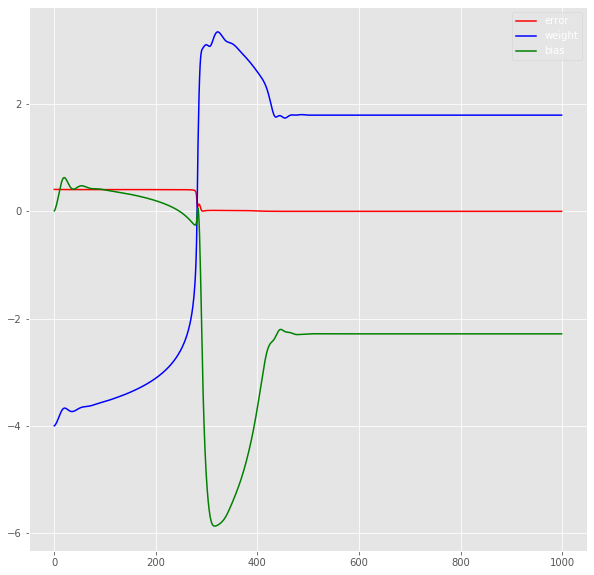

In [194]:
sigmoidneuron = SigmoidNeuron(w_init, b_init, algo)

sigmoidneuron.fit(X, Y, epochs = 1000, eta = 1)
 
plt.style.use('ggplot')
plt.figure(figsize = (10,10))
plt.plot(sigmoidneuron.e_h, 'r', label = 'error')
plt.plot(sigmoidneuron.w_h, 'b', label = 'weight')
plt.plot(sigmoidneuron.b_h, 'g', label = 'bias')
plt.legend()
plt.show()

In [195]:
def plot_animate_3d(i):
    i = int(i * (epochs/animation_frames))
    line1.set_data(sigmoidneuron.w_h[:i+1], sigmoidneuron.b_h[:i+1])
    line1.set_3d_properties(sigmoidneuron.e_h[:i+1])
    line2.set_data(sigmoidneuron.w_h[:i+1], sigmoidneuron.b_h[:i+1])
    line1.set_3d_properties(np.zeros(i+1) - 1)
    title.set_text('Epoch: {:d}, Error:{:.4f}'.format(i, sigmoidneuron.e_h[i]))
    return line1, line2, title

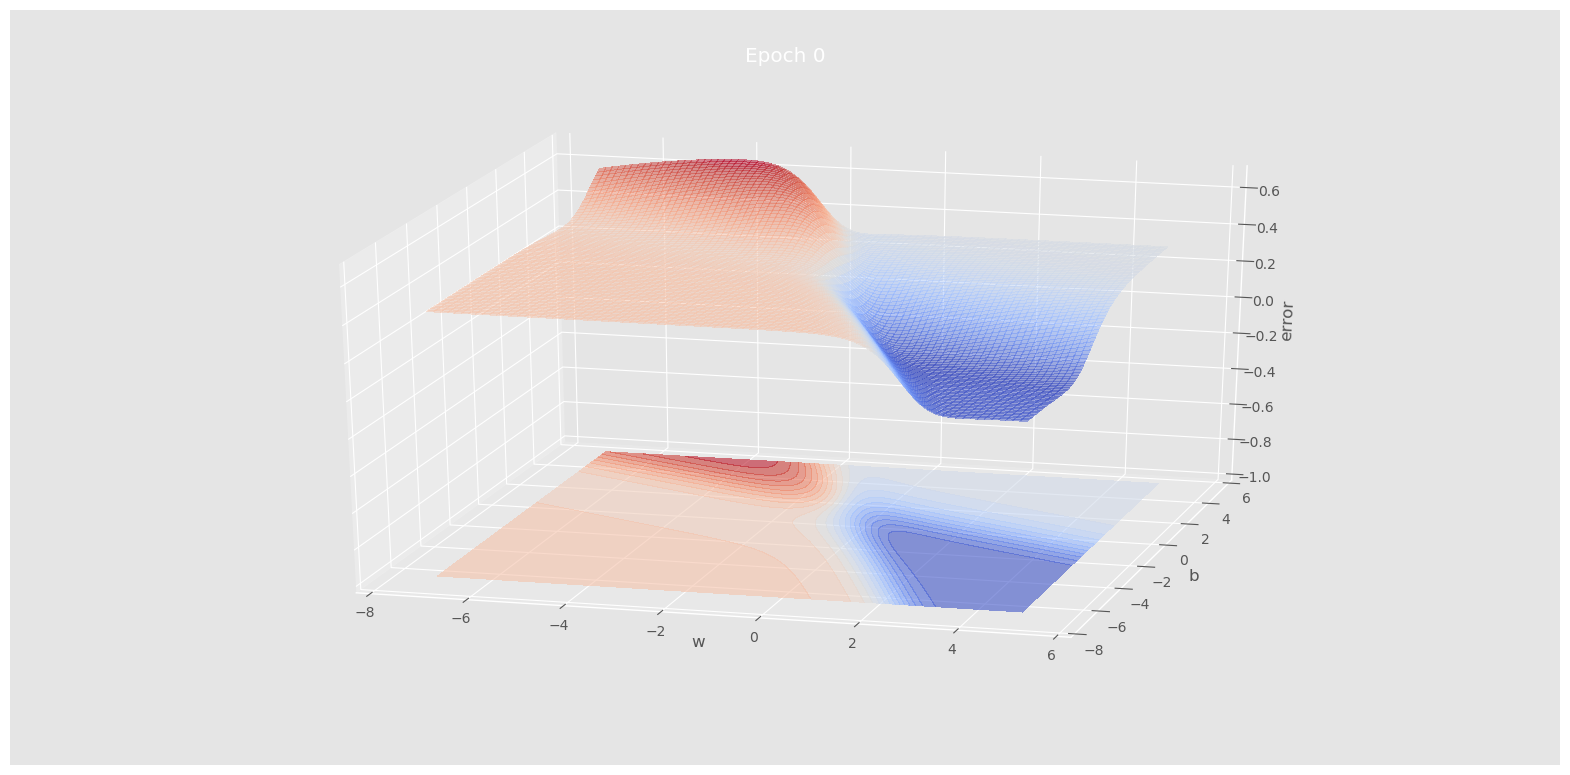

In [196]:
if plot_3d:
    W = np.linspace(w_min, w_max, 256)
    b = np.linspace(b_min, b_max, 256)
    
    WW, BB = np.meshgrid(W, b)
    Z = sigmoidneuron.error(X, Y, WW, BB)
    
    fig = plt.figure(dpi = 100, figsize=(20,10))
    ax = fig.gca(projection = '3d')
    surf = ax.plot_surface(WW, BB, Z, rstride = 3, cstride = 3, alpha = 0.5, 
                          cmap = cm.coolwarm, linewidth = 0, antialiased = False)
    cset = ax.contourf(WW, BB, Z, 25, zdir = 'z', offset = -1, alpha = 0.6, cmap = cm.coolwarm)
    ax.set_xlabel('w')
    ax.set_xlim(w_min - 1, w_max + 1)
    ax.set_ylabel('b')
    ax.set_ylim(b_min - 1, w_max + 1)
    ax.set_zlabel('error')
    ax.set_zlim(-1, np.max(Z))
    ax.view_init(elev = 25, azim = -75)
    ax.dist = 12
    title = ax.set_title('Epoch 0')
    
    

In [197]:
if plot_3d:
    i = 0
    line1, = ax.plot(sigmoidneuron.w_h[:i+1], sigmoidneuron.b_h[:i+1], sigmoidneuron.e_h[:i+1], color = 'black', marker ='.')
    line2, = ax.plot(sigmoidneuron.w_h[:i+1], sigmoidneuron.b_h[:i+1], np.zeros(i+1) - 1, color = 'red', marker ='.')
    anim = animation.FuncAnimation(fig, func = plot_animate_3d, frames = animation_frames)
    rc('animation', html = 'jshtml')
    anim

In [198]:
if plot_2d:
    W = np.linspace(w_min, w_max, 256)
    b = np.linspace(b_min, b_max, 256)
    WW, BB = np.meshgrid(W, b)
    Z = sigmoidneuron.error(X, Y, WW, BB)
    
    fig = plt.figure(dpi = 100, figsize = (10, 10))
    ax = plt.subplot(111)
    ax.set_xlabel('w')
    ax.set_xlim(w_min - 1, w_max + 1)
    ax.set_ylabel('b')
    ax.set_xlim(b_min - 1, b_max + 1)
    titile = ax.set_title('Epoch 0')
    cset = plt.contourf(WW, BB, Z, 25, alpha = 0.6, cmap = cm.bwr)
    plt.show()

In [199]:
def plot_animate_2d(i):
    i = int(i * (epochs / animation_frames))
    line.set_data(sigmoidneuron.w_h[:i+1], sigmoidneuron.b_h[:i+1])
    title.set_text('Epoch: {:d}, Error: {:.4f}'.format(i, sigmoidneuron.e_h[i]))
    return line, title

In [200]:
if algo == 'GradientDescent':
    print('algo = {}, eta = {}'.format(algo, eta))

elif algo == 'MomentumGD':
    print('algo = {}, eta = {}'.format(algo, eta))

elif algo == 'NAG':
    print('algo = {}, eta = {}'.format(algo, eta))

elif algo == 'MiniBatch':
    print('algo = {}, eta = {}'.format(algo, eta))

elif algo == 'AdaGrad':
    print('algo = {}, eta = {}'.format(algo, eta))

elif algo == 'RMSProp':
    print('algo = {}, eta = {}'.format(algo, eta))


elif algo == 'Adam':
    print('algo = {}, eta = {}'.format(algo, eta))

anim